In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d
import os, sys, glob
import laspy as lp
from time import process_time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Compute LAI and LAD from foliage point cloud

This notebook asumes that you already removed the trunk and branches from trees, and that you have segmentated the trees and put it in individual PCD files.

In [2]:
#
datapath = '../data/mock_vel2/toy_trees/' #path of segmented trees
rawpath = '../data/mock_vel2' # path with raw numpy data from blensor

files = glob.glob(os.path.join(datapath, 'tree_*.npy'))
files_raw = glob.glob(os.path.join(rawpath, 'toy0*.numpy'))

tree = np.load(files[0])
points = tree.T[5:8].T # x,y, and z coordinates


In [11]:
#
voxel_size=0.1

In [3]:
# pcd = points2pcd(bps)
# downpcd = o3d.geometry.PointCloud.voxel_down_sample(pcd, voxel_size=0.2)
# o3d.visualization.draw_geometries([downpcd])

### Trace back laser beam with Laser Beam Angles `Pitch` and `Yaw`

In [4]:
# Get laser beam direction from YAW and PITCH

def beam_direction(yaw, pitch):
    
    x = np.cos(yaw)*np.cos(pitch)
    y = np.sin(yaw)*np.cos(pitch)
    z = np.sin(pitch)
    
    points = np.vstack((np.array(x), np.array(y), np.array(z))).transpose()
    
    return points

#
def trace_beam(points, beam_angles, distance, res=0.1):

    tracers = {'p':[], 'pb':[], 'linepts':[]}

#     beam_angles = np.vstack((np.array(df['yaw']), np.array(df['pitch']))).transpose()
#     dist = np.array(df['distance'])

    # unitary vector with direction of beam from camera point of view
    uv = beam_direction(beam_angles.T[0], beam_angles.T[1]) 

    for i in range(uv.shape[0]):
        
        # proyect unitary vector to actual distance of beam and invert it to point cloud data view
        N = int(distance[i]/res)
        pb = -1 * uv[i] * np.linspace(0.01, distance[i], N)[:, np.newaxis] # this traces the beam with N points

        # Moving proyected unitary vector (i.e. the beam) to its reall position
        linepts = points[i] + pb

        # create matrix with position of the origin beam and position of the intersected beam
#         twopoints = np.vstack([p[i], linepts[-1]])

        tracers['p'].append(points[i])
        tracers['pb'].append(linepts[-1])
        tracers['linepts'].append(linepts)
        
    return tracers

#
def get_beams_traces(foliage_points, files, res=0.1):
    """
    Get beam traces points within plant region.
    """

    beam_points_wpr = []
    # read the numpy files
    for file in files:

        df = np.loadtxt(file)
        if len(df) == 0: continue
        filename = file.split('/')[-1]
#         print(filename)
        points = df.T[5:8].T # x,y, and z coordinates
        beam_angles = df.T[1:3].T # Pitch and Yaw
        distance = df.T[3:4].T # distance from UAV to intercepted point

        tracers = trace_beam(points, beam_angles, distance, res=res)
        beam_points = np.vstack(tracers['linepts'])
        beam_points = beam_points.reshape(beam_points.shape[0], beam_points.shape[2])
    #     print(beam_points.shape)

        # filter within plant region
        keep = np.ones(beam_points.shape[0], dtype=bool)
        for i in range(3):
            keep &= np.logical_and(beam_points[:,i] >= foliage_points[:,i].min(),
                                   beam_points[:,i] <= foliage_points[:,i].max())

        print('%s \t beam traces points: \t %i --> %i' %(filename, len(keep), np.sum(keep)))
        if np.sum(keep) > 0:
            beam_points_wpr.append(beam_points[keep])

    return beam_points_wpr

In [5]:
# %time tracers = trace_beam(points, beam_angles, distance, res=0.02)
tracers = get_beams_traces(points, files_raw, res=0.04)

toy00022.numpy 	 beam traces points: 	 2131929 --> 0
toy00023.numpy 	 beam traces points: 	 16974912 --> 0
toy00004.numpy 	 beam traces points: 	 30574361 --> 16265
toy00008.numpy 	 beam traces points: 	 6555339 --> 0


<ipython-input-4-ce3fe4b41c9e>:52: UserWarning: loadtxt: Empty input file: "../data/mock_vel2/toy00003.numpy"
  df = np.loadtxt(file)


toy00020.numpy 	 beam traces points: 	 18774914 --> 508840
toy00009.numpy 	 beam traces points: 	 11926387 --> 65268
toy00016.numpy 	 beam traces points: 	 12426342 --> 0
toy00007.numpy 	 beam traces points: 	 30502621 --> 58684
toy00017.numpy 	 beam traces points: 	 24845397 --> 867231
toy00021.numpy 	 beam traces points: 	 9932840 --> 0
toy00012.numpy 	 beam traces points: 	 7670035 --> 0


<ipython-input-4-ce3fe4b41c9e>:52: UserWarning: loadtxt: Empty input file: "../data/mock_vel2/toy00033.numpy"
  df = np.loadtxt(file)


toy00030.numpy 	 beam traces points: 	 15548409 --> 1707989
toy00034.numpy 	 beam traces points: 	 20225821 --> 782569
toy00025.numpy 	 beam traces points: 	 25643497 --> 23097
toy00028.numpy 	 beam traces points: 	 355811 --> 0


<ipython-input-4-ce3fe4b41c9e>:52: UserWarning: loadtxt: Empty input file: "../data/mock_vel2/toy00036.numpy"
  df = np.loadtxt(file)
<ipython-input-4-ce3fe4b41c9e>:52: UserWarning: loadtxt: Empty input file: "../data/mock_vel2/toy00001.numpy"
  df = np.loadtxt(file)


toy00010.numpy 	 beam traces points: 	 8372113 --> 0
toy00029.numpy 	 beam traces points: 	 15221259 --> 241845
toy00013.numpy 	 beam traces points: 	 29892853 --> 186737
toy00032.numpy 	 beam traces points: 	 48680654 --> 617212
toy00011.numpy 	 beam traces points: 	 27746726 --> 155197
toy00015.numpy 	 beam traces points: 	 5899816 --> 321106
toy00014.numpy 	 beam traces points: 	 25689624 --> 111496
toy00018.numpy 	 beam traces points: 	 2317276 --> 37988
toy00027.numpy 	 beam traces points: 	 14389814 --> 1069
toy00035.numpy 	 beam traces points: 	 1531685 --> 0
toy00024.numpy 	 beam traces points: 	 13829988 --> 400489
toy00005.numpy 	 beam traces points: 	 4271248 --> 0
toy00000.numpy 	 beam traces points: 	 11094891 --> 0


<ipython-input-4-ce3fe4b41c9e>:52: UserWarning: loadtxt: Empty input file: "../data/mock_vel2/toy00031.numpy"
  df = np.loadtxt(file)


toy00026.numpy 	 beam traces points: 	 15161780 --> 3146642
toy00006.numpy 	 beam traces points: 	 3085419 --> 0
toy00019.numpy 	 beam traces points: 	 16716944 --> 0
toy00002.numpy 	 beam traces points: 	 23374113 --> 12324


In [6]:
tracers = np.vstack(tracers)
print(tracers.shape)

(9262048, 3)


In [7]:
# beam_points = np.vstack(tracers['linepts'])
# print(beam_points.shape)
# # reshape
# beam_points = beam_points.reshape(beam_points.shape[0], beam_points.shape[2])
# print(beam_points.shape)

### Get normals

In [8]:
#

def points2pcd(points):
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=np.asarray(pcd.points).shape))
    
    return pcd

def get_normals(points, sr=0.1, max_nn=30, show=False):
    
    pcd = points2pcd(points)
    
    o3d.geometry.PointCloud.estimate_normals(pcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=sr,max_nn=max_nn))
    
    if show:
        
        downpcd = o3d.geometry.PointCloud.voxel_down_sample(pcd, voxel_size=0.5)
        o3d.visualization.draw_geometries([downpcd])
        
    return np.asarray(pcd.normals)


In [9]:
normals = get_normals(points=points, show=True)

### Get the Leaf Inclination Angle ($\theta_{L}$)

In [10]:
#

def vecttoangle(v1, v2):
    
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    
    return np.rad2deg(angle)

def get_leaf_angle(points, normals, voxel_size, show=False):
    
    t1 = process_time()
    
    pcd = points2pcd(points)
    
    # Voxelizing the PCD
    print('voxelization')
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size)
        
    # get voxel ID for each point
    voxel = []
    queries = points

    for vox in queries:

        i,j,k = voxel_grid.get_voxel(vox)
        voxel.append('%s_%s_%s' %(i,j,k))

    print('N voxels: %i' %(len(set(voxel))))
    print('Voxel size: \t %.2f' %(voxel_size))
    
    # 
    angs = {'voxID':[], 'avgVect':[], 'avgAngle':[], 'N':[]}

    #
    vox, idx, idxinv, counts = np.unique(np.array(voxel), return_index=True, return_inverse=True, return_counts=True)

    for num, vx in enumerate(vox):

        keep = np.where(idxinv == num)

        angs['voxID'].append(vx)
        angs['N'].append(counts[num])

        # average all normals within voxel
        avgVect = normals[keep].sum(axis=0)
        angs['avgVect'].append(avgVect)

        # get angle with respect to z axis from average normals
        ang = vecttoangle([0, 0, 1], -avgVect)
        angs['avgAngle'].append(np.round(ang, 1))

    t2 = process_time()
    print('Total time:', t2-t1)
    
    if show:
        o3d.visualization.draw_geometries([voxel_grid])
        
    return angs
    

In [12]:
angs = get_leaf_angle(points, normals, voxel_size, show=True)

voxelization
N voxels: 3729
Voxel size: 	 0.10
Total time: 0.49466360099998496


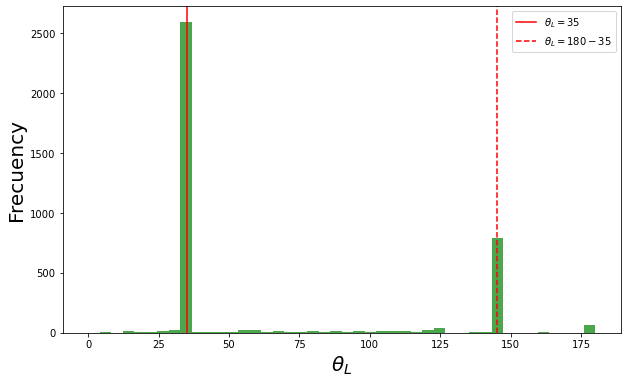

In [13]:
plt.figure(figsize=(10,6))

bins = np.linspace(0, 180, int(180/4))

plt.hist(angs['avgAngle'], bins=bins, color='g', alpha=0.7)
plt.axvline(35, c='r', label=r'$\theta_{L}=35$')
plt.axvline(180-35, c='r', ls='--', label=r'$\theta_{L}=180-35$')

plt.ylabel(r'Frecuency', size=20)
plt.xlabel(r'$\theta_{L}$', size=20)
plt.legend()
plt.show()

## Find atributes

In [14]:
#
def get_voxels(voxel_grid):
    
    voxels = []
    for i in voxel_grid.get_voxels():
#         voxels.append('_'.join(str(j) for j in i.grid_index.tolist()))
        voxels.append(i.grid_index.tolist())
    
    return np.array(voxels)

def idx_bounds(voxel_idx, show=False):
    
    # get i,j,k max and min
    vdict = {}
    vdict['ijk_max'] = [voxel_idx.T[i].max() for i in [0,1,2]]
    vdict['ijk_min'] = [voxel_idx.T[i].min() for i in [0,1,2]]
    
    if show:
        print('max -->', vdict['ijk_max'])
        print('min -->', vdict['ijk_min'])
        
    return vdict

#
def within_bounds(voxel_idx, voxel_idx_bounds):
    
    vdict = idx_bounds(voxel_idx_bounds, False)
    
    keep = np.ones(voxel_idx.shape[0], dtype=bool)
    for i in range(3):
        keep &= np.logical_and(vdict['ijk_min'][i] <= voxel_idx[:,i], vdict['ijk_max'][i] >= voxel_idx[:,i])
        
    # Check 3D matrix i,j,k size matches length of solid voxel grid index array: i*j*k == voxs_idx.shape[0]
    vdict = idx_bounds(voxel_idx[keep], False)
    assert np.product(np.array(vdict['ijk_max'])+1) == voxel_idx_bounds.shape[0]
        
    return voxel_idx[keep]

#
def get_attributes(m3shape, m3p, m3b, show=False):
    
    # 3D matrix full with attribute 3
    m3att = np.full(m3shape, 3, dtype=int)
    
    # fill with attribute 2
    m3att[m3b] = 2
    
    # fill with attribute 1
    m3att[m3p] = 1
    
    assert (m3att == 3).sum() == (~(m3b & (~m3p) | (m3p))).sum()
    assert (m3att == 2).sum() == (m3b & (~m3p)).sum()
    assert (m3att == 1).sum() == m3p.sum()
    
    if show:
        for i in range(1,4):
            print('Number of voxels with attribute %i: \t %i' %(i, (m3att == i).sum()))

    return m3att


In [16]:
# get points voxel bounding box
pcd = points2pcd(points)
voxp = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)
# voxp.get_axis_aligned_bounding_box()

# Voxelize the beam points with same bounding box dimensions as the points voxel grid
pcd = points2pcd(tracers)
voxb = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(pcd, voxel_size=voxel_size, 
                                                                    min_bound=voxp.get_min_bound().reshape(3,1), 
                                                                    max_bound=voxp.get_max_bound().reshape(3,1))

# Create voxel of plant region
width, height, depth = voxp.get_max_bound() - voxp.get_min_bound()
print(width, height, depth)
voxs = o3d.geometry.VoxelGrid.create_dense(origin=voxp.origin, color=np.array([0,0,1]), voxel_size=voxel_size, width=width, height=height, depth=depth)


6.100000000000001 6.1000000000000005 4.5


In [17]:
# Get solid voxel grid indexes
voxs_idx = get_voxels(voxs)

# get i,j,k max and min
vdict = idx_bounds(voxs_idx, True)
ijk_bounds = np.array(list(vdict.values())).reshape(1,6)[0]

# check that all index (i,j and k) are positive
if np.any(ijk_bounds < 0):
    raise ValueError('Solid voxel grid found negative (i,j,k) values.')

# create 3D boolean matrix of i,j,k size
m3s = np.zeros(np.array(vdict['ijk_max'])+1, dtype=bool)
m3s.shape

# Check 3D matrix i,j,k size matches length of solid voxel grid index array: i*j*k == voxs_idx.shape[0]
assert np.product(np.array(vdict['ijk_max'])+1) == voxs_idx.shape[0]

max --> [60, 60, 44]
min --> [0, 0, 0]


In [18]:
# get voxel grid indexes for points and beams voxels
voxp_idx = get_voxels(voxp)
voxb_idx = get_voxels(voxb)

# get rid of voxels outside the plant region
voxp_idx = within_bounds(voxp_idx, voxs_idx)
voxb_idx = within_bounds(voxb_idx, voxs_idx)

# fill 3D matrix with True if voxel exist
m3p = m3s.copy()
for (i,j,k) in voxp_idx:
    
    m3p[i][j][k] = True
    
print('Number of voxels ocupied by points cloud: \t %i' %(m3p.sum()))

m3b = m3s.copy()
for (i,j,k) in voxb_idx:
        
    m3b[i][j][k] = True
    
print('Number of voxels ocupied by beam points cloud: \t %i' %(m3b.sum()))
print('Total number of voxels in plant regions: \t %i' %((~m3s).sum()))


Number of voxels ocupied by points cloud: 	 3729
Number of voxels ocupied by beam points cloud: 	 158101
Total number of voxels in plant regions: 	 167445


In [19]:
m3att = get_attributes(m3s.shape, m3p, m3b, True)

Number of voxels with attribute 1: 	 3729
Number of voxels with attribute 2: 	 154379
Number of voxels with attribute 3: 	 9337


In [20]:
m3att.shape

(61, 61, 45)

## Computing $G(\theta)$

$G(\theta)$ is the mean projection of a unit leaf area on a plane perpendicular to the direction of the laser beam. This quantity is determined with the assumption that leaves are positioned symmetrically with respect to the azimuth anc can be represented as:

$$G(\theta) =  \sum_{q=1}^{T_{q}} g(q) S(\theta, \theta_{L}(q))$$

where $S(\theta, \theta_{L}(q))$ is expresed in terms of the leaf in-inclination angle $\theta_{L}$ (the zenith angle of the normal to the leaf surface), and $\theta$ is the laser-beam incident zenith angle:

$$S(\theta, \theta_{L}) = \cos\theta \cos \theta_{L}, \hspace{.5cm} \textrm{for } \theta \leq \pi/2 - \theta_{L}$$
$$S(\theta, \theta_{L}) = \cos\theta \cos \theta_{L} \left[ 1 + \frac{2}{\pi}(\tan x - x) \right], \hspace{.5cm} \textrm{for } \theta \gt \pi/2 - \theta_{L}$$

$$x = \cos^{-1}\left( \cot \theta \cot \theta_{L} \right).$$

Here $q$ is the leaf-inclination-angle class and Tq is the total number of leaf-inclination-angle classes. Thus, if there are $18$ leaf-inclination-angle classes from $0◦$ to $90◦$ ($Tq = 18$), then each class consists of a $5◦$ interval. For example, $q = 1$, $q = 9$, and $q = 16$ include the angles from $0◦$ to $4◦$, $40◦$ to $44◦$, and $75◦$ to $79◦$, respectively. $g(q)$ is the distribution of the leaf-inclination-angle class $q$, which is a ratio of the leaf area belonging to class $q$ to total leaf area; $θ_{L}(q)$ is the midpoint angle of class $q$, which is the leaf-inclination angle used to represent class $q$.



### Correcting $\theta_{L}$

Since we want angles with respect to the zenith, we will correct for angles above $\pi/2$ as follow:

$$\theta_{L} = \theta_{l}, \hspace{0.5cm} \textrm{for } \theta_{l} \leq \pi/2,$$
$$\theta_{L} = \pi - \theta_{l}, \hspace{0.5cm} \textrm{for } \theta_{l} \gt \pi/2,$$

where $\theta_{l}$ is the average angle we get with the `get_leaf_angle` function.


In [21]:
# correct \theta_{L}
thetaL = [i if (i < 90) else (180 - i) for i in angs['avgAngle']]

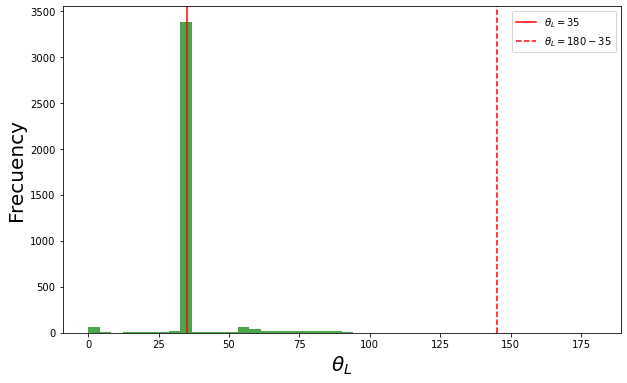

In [22]:
#
plt.figure(figsize=(10,6))

bins = np.linspace(0, 180, int(180/4))

plt.hist(thetaL, bins=bins, color='g', alpha=0.7)
plt.axvline(35, c='r', label=r'$\theta_{L}=35$')
plt.axvline(180-35, c='r', ls='--', label=r'$\theta_{L}=180-35$')

plt.ylabel(r'Frecuency', size=20)
plt.xlabel(r'$\theta_{L}$', size=20)
plt.legend()
plt.show()

### Computing $G(\theta)$

In [23]:
#
def stheta(theta, thetaLq):
    
    x = lambda theta, thetaLq : 1/np.cos(np.arctan(np.tan(theta))*np.arctan(np.tan(thetaLq)))
    
    if theta <= np.pi/2 - thetaLq:
        s = np.cos(theta)*np.cos(thetaLq)
        
    elif theta > np.pi/2 - thetaLq:
        s = np.cos(theta)*np.cos(thetaLq)*(1 + 2*(np.tan(x(theta, thetaLq)) - x(theta, thetaLq))/np.pi)
    else:
        raise ValueError('theta=%.2f and/or thetaL=%.2f fails condition' %(theta, thetaLq))
        
    return s
    
def Gtheta(theta, thetaL, tq, norm=True):
    
    """
    Compute the G(\theta).
    
    theta:  float::  beam-angle in degrees
    thetaL: float-array:: leaf-inclination-angle distribution in degrees
    tq: int:: total number of leaf-inclination-angle classes
    """
    
    bins = np.linspace(0, 90, tq+1)
    gtot = len(thetaL)
    Gtheta_i = []

    for q in range(len(bins)-1):
        
        keep = np.logical_and(thetaL >= bins[q], thetaL < bins[q+1])
        if norm: gqi = np.sum(keep)/gtot # normalize the inclination-angle distribution?
        else: gqi = np.sum(keep)
        thetaLq = np.median(np.array(thetaL)[keep])
        sthetaq = stheta(np.radians(np.array(theta)), np.radians(np.array(thetaLq)))
        Gtheta_i.append(gqi*sthetaq)

#         print(gqi*sthetaq)
#     print('Total: ',np.array(Gtheta_i).sum())

    return np.array(Gtheta_i).sum()
    

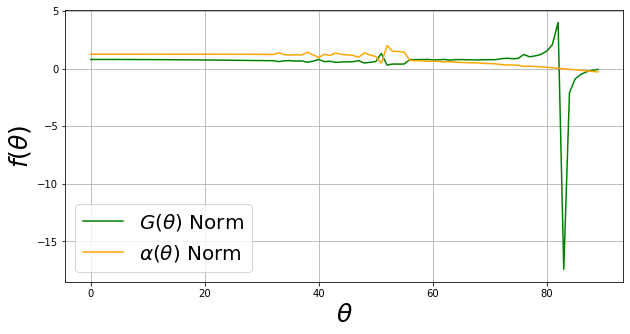

In [24]:
#
Gthetas = np.array([[i, Gtheta(i, thetaL, 18)] for i in range(90)])
Gthetas_nn = np.array([[i, Gtheta(i, thetaL, 18, norm=False)] for i in range(90)])
    
# plot
plt.figure(figsize=(10,5))
plt.plot(Gthetas[:,0], Gthetas[:,1], c='g', label=r'$G(\theta)$ Norm')
plt.plot(Gthetas[:,0], np.cos(np.radians(Gthetas[:,0]))/Gthetas[:,1], c='orange', label=r'$\alpha(\theta)$ Norm')
# plt.plot(Gthetas_nn[:,0], Gthetas_nn[:,1], c='g', ls='--', label='not Norm')
plt.xlabel(r'$\theta$', size=25)
plt.ylabel(r'$f(\theta)$', size=25)
plt.legend(loc='lower left', fontsize=20)
plt.grid()
plt.show()

## Computing `LAD`

``` python
# plant region dimensions
width, height, depth = voxp.get_max_bound() - voxp.get_min_bound()
# how many voxels to use for DeltaH?
# This has to be > 2
Nvox = int(2)
kvoxes = int(m3att.shape[2])
# correct to Nvox without residual if necesary
Nvox = kvoxes/(kvoxes//Nvox)

# voxel_size = 0.2
DeltaH = np.round(Nvox*voxel_size, 4)
print(Nvox, DeltaH)
```

In [25]:
#
def get_lad_perk(kcoord, m3att, alpha, voxel_size):
    
    ki, kf = kcoord
    
    if kf > m3att.shape[2]:
        raise ValueError('k values cannot be greater than available. Maximum K value is: %i' %(m3att.shape[2]))
    
    m3 = m3att[:,:,ki:kf]
    DeltaH = (kf-ki) * voxel_size
    lai = []
    
    for i in range(kf-ki):
        
        nI = (m3[:,:,i] == 1).sum()
        nP = (m3[:,:,i] == 2).sum()
        lai.append(nI/(nI+nP))
#         print(i, nI, nP, nI/(nI+nP))
#         print(i, nI/(nI+nP), DeltaH)
        
    LAD = alpha * (1/DeltaH) * np.array(lai).sum()
#     print(alpha, 1/DeltaH, np.array(lai).sum(), LAD)
#     print(ki*voxel_size+DeltaH/2., LAD)

    return ki*voxel_size+DeltaH/2., LAD
    

In [26]:
#
def get_LADS(m3att, alpha, voxel_size, kbins):
    
    kmax = m3att.shape[2]
    ar = np.arange(0, kmax, kbins)
    kcoords = []
    lads = []

    for i in range(len(ar)-1):
        kcoords.append([ar[i],ar[1:][i]])

    kcoords.append([ar[-1], kmax])
    
#     print(kcoords)
    for i in kcoords:
        h, lad = get_lad_perk(i, m3att, alpha, voxel_size)
        lads.append([h, lad])
        
    return np.array(lads)


### Comparison with truth

In [27]:
#
# file = "../data/mock_vel2/toy_trees.ply"
def true_lad(file, DeltaH, leafang):
    
    mesh = o3d.io.read_triangle_mesh(file)
    bxi, byi, bzi = mesh.get_min_bound()
    bxf, byf, bzf = mesh.get_max_bound()
    lx, ly = np.abs(bxf - bxi), np.abs(byf - byi)
    
    #divide heigth in bins
    ar = np.arange(bzi, bzf, DeltaH)
    kcoords = []
    for i in range(len(ar)-1):
        kcoords.append([ar[i],ar[1:][i]])
    kcoords.append([ar[-1], bzf])
    
    #compute true lad per bin
    lads = []
    # crop mesh for each bin
    for i in kcoords:
        bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(bxi, byi, i[0]), max_bound=(bxf, byf, i[1]))
        _mesh = mesh.crop(bbox)
        # get surface of croped mesh
        A = _mesh.get_surface_area()
        # correct by leaf inclination
        Areal = A*np.cos(np.radians(leafang))
#         print('%.2f < z < %.2f: \t A=%.2f \t Areal=%.2f' %(i[0], i[1], A, Areal))
        
        #get volume per bin
        lz = np.abs(i[1] - i[0])
        volume = lx * ly * lz
        
        #save lad
        lads.append([i[0]+lz/2., Areal/volume])
        
    return np.array(lads)


In [28]:
#
file = "../data/mock_vel2/toy_trees.ply"
alpha = 0.2
# voxel_size = 0.2
kbins = 3
DeltaH = voxel_size * kbins

tlads = true_lad(file, DeltaH, leafang=35)
lads = get_LADS(m3att, alpha, voxel_size, kbins)

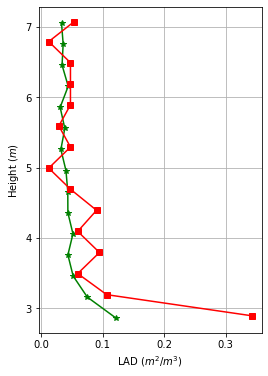

In [29]:
#
_,_,z = voxp.get_min_bound()
#
plt.figure(figsize=(4, 6))
plt.plot(lads[0:,1], z+lads[0:,0], marker='*', c='g')
plt.plot(tlads[0:,1], tlads[0:,0], marker='s', c='r')
plt.xlabel(r'LAD ($m^2/m^3$)')
plt.ylabel(r'Height ($m$)')
plt.grid()
plt.show()

In [33]:
print("Testing mesh in open3d ...")
print(mesh)
print(np.asarray(mesh.vertices))
print(np.asarray(mesh.triangles))
print("")

Testing mesh in open3d ...
TriangleMesh with 4068 points and 2220 triangles.
[[-15.886806   0.148137   2.747738]
 [-15.745987   0.12655    2.795416]
 [-15.70449    0.180857   2.843094]
 ...
 [-16.         3.031401   7.209926]
 [-16.125      2.963138   7.162128]
 [-16.125      2.894876   7.11433 ]]
[[   0    1    2]
 [   0    2    3]
 [   4    5    6]
 ...
 [4060 4062 4063]
 [4064 4065 4066]
 [4064 4066 4067]]



In [127]:
print("Computing normal and rendering it.")
mesh.compute_vertex_normals()
print(np.asarray(mesh.triangle_normals))
o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True)

Computing normal and rendering it.
[[-3.47376234e-01 -4.54609091e-01  8.20158720e-01]
 [-3.47376475e-01 -4.54608464e-01  8.20158966e-01]
 [-3.47371150e-01 -4.54612533e-01  8.20158966e-01]
 ...
 [-1.52953644e-06 -5.73576164e-01  8.19152235e-01]
 [ 1.52953644e-06 -5.73576164e-01  8.19152235e-01]
 [-4.58863939e-06 -5.73579923e-01  8.19149603e-01]]
